# Introduction

This notebook contains the application of 3 data visualization techniques (PCA, LLE, t-SNE) on the same dataset. The data originates from a study about marriage done in Turkey by Y&ouml;ntem et al.. Married and divorced participants were asked to fill in a questionaire that contained statements regarding their (unsuccesful) marriage. Examples of statements are: 'My spouse and I have similar ideas about how marriage should be.' and 'I enjoy traveling with my wife.'. Participants were asked to choose options such as 'strongly agree' and 'disagree', which were converted to an integer between 0 and 4. A 0 corresponds to 'strongly agree' and 4 corresponds with 'strongly disagree'. The dataset consists of 170 participants, who each rated 54 statements about their marriage.

Data source: https://archive.ics.uci.edu/ml/datasets/Divorce+Predictors+data+set

Relevant paper by Y&ouml;ntem et al.: https://dergipark.org.tr/en/pub/nevsosbilen/issue/46568/549416

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import models
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# Load data

In [2]:
data_dir = 'data'

with open(os.path.join(data_dir, 'divorce.csv')) as data_file:
    data = pd.read_csv(data_file, delimiter=';')

X =  data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1].to_numpy()

n_participants = X.shape[0]
n_features = X.shape[1]

print('Number of data points/participants:', n_participants)
print('Number of features/statements:', n_features)

# True/False arrays to create divorced/married subsets of the data
divorced = y.astype(bool)
married = ~divorced

Number of data points/participants: 170
Number of features/statements: 54


# Further comments on the data

Features meaning (may be counterintuitive): 0 = 'strongly agree', 4 = 'strongly disagree' 

Labels meaning: 0 = 'married', 1 = 'divorced'

The words 'wife' and 'spouse' should be considered interchangeable in the statements.
The statements are presumably translated from Turkish 
and the meaning of the statements in English is unfortunately not always 100% clear.

Data was collected through face-to-face interviews and Google drive questionaires. 
Divorced participants were asked to reflect back(!) on their marriage.
Married participants only included happy marriages, i.e. those that did not have any thoughts about divorce.

Reported characteristics of participants:
- divorced: 84 (49%), married 86 (51%) 
- male 84 (49%), female 86 (51%) 
- age: min 20, max 63, mean 36.04, std 9.34
- 7 different regions in Turkey, predominantly from the Black Sea region 79 (46.4%)
- married for love 74 (43.5%), arranged marriage 96 (56.5%) 
- with children 127 (74.7%), without children 43 (25.3%)
- primary school graduate 18 (10.58%), secondary school graduate 15 (8.8%), high school graduate 33 (19.41%),
college graduate 88 (51.76%), master degree 15 (8.8%)
- income: <2000 TL 34 (20%), 2001-3000 TL 54 (31.76%), 3001-4000 TL 28 (16.47%), >4000 TL 54 (31.76%)

Another analysis of the data: (statements 9, 11, 18, 19, 26, and 40 are determined to be the best predictors):

https://ongjk.github.io/supervise.html

Kaggle also has the dataset: (note the statements are sometimes formulated differently in the description on Kaggle):

https://www.kaggle.com/adisak/divorce-predictors-data-set

In [3]:
statements = {'1': "If one of us apologizes when our discussion deteriorates, the discussion ends.",
'2': "I know we can ignore our differences, even if things get hard sometimes.",
'3': "When we need it, we can take our discussions with my spouse from the beginning and correct it.",
'4': "When I discuss with my spouse, to contact him will eventually work.",
'5': "The time I spent with my wife is special for us.",
'6': "We don't have time at home as partners.",
'7': "We are like two strangers who share the same environment at home rather than family.",
'8': "I enjoy our holidays with my wife.",
'9': "I enjoy traveling with my wife.",
'10': "Most of our goals are common to my spouse.",
'11': "I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other.",
'12': "My spouse and I have similar values in terms of personal freedom.",
'13': "My spouse and I have similar sense of entertainment.",
'14': "Most of our goals for people (children, friends, etc.) are the same.",
'15': "Our dreams with my spouse are similar and harmonious.",
'16': "We're compatible with my spouse about what love should be.",
'17': "We share the same views about being happy in our life with my spouse",
'18': "My spouse and I have similar ideas about how marriage should be",
'19': "My spouse and I have similar ideas about how roles should be in marriage",
'20': "My spouse and I have similar values in trust.",
'21': "I know exactly what my wife likes.",
'22': "I know how my spouse wants to be taken care of when she/he sick.",
'23': "I know my spouse's favorite food.",
'24': "I can tell you what kind of stress my spouse is facing in her/his life.",
'25': "I have knowledge of my spouse's inner world.",
'26': "I know my spouse's basic anxieties.",
'27': "I know what my spouse's current sources of stress are.",
'28': "I know my spouse's hopes and wishes.",
'29': "I know my spouse very well.",
'30': "I know my spouse's friends and their social relationships.",
'31': "I feel aggressive when I argue with my spouse.",
'32': "When discussing with my spouse, I usually use expressions such as ‘you always’ or ‘you never’ .",
'33': "I can use negative statements about my spouse's personality during our discussions.",
'34': "I can use offensive expressions during our discussions.",
'35': "I can insult my spouse during our discussions.",
'36': "I can be humiliating when we discussions.",
'37': "My discussion with my spouse is not calm.",
'38': "I hate my spouse's way of open a subject.",
'39': "Our discussions often occur suddenly.",
'40': "We're just starting a discussion before I know what's going on.",
'41': "When I talk to my spouse about something, my calm suddenly breaks.",
'42': "When I argue with my spouse, ı only go out and I don't say a word.",
'43': "I mostly stay silent to calm the environment a little bit.",
'44': "Sometimes I think it's good for me to leave home for a while.",
'45': "I'd rather stay silent than discuss with my spouse.",
'46': "Even if I'm right in the discussion, I stay silent to hurt my spouse.",
'47': "When I discuss with my spouse, I stay silent because I am afraid of not being able to control my anger.",
'48': "I feel right in our discussions.",
'49': "I have nothing to do with what I've been accused of.",
'50': "I'm not actually the one who's guilty about what I'm accused of.",
'51': "I'm not the one who's wrong about problems at home.",
'52': "I wouldn't hesitate to tell my spouse about her/his inadequacy.",
'53': "When I discuss, I remind my spouse of her/his inadequacy.",
'54': "I'm not afraid to tell my spouse about her/his incompetence."}

# Some examples of how divorced and married participants responded
# to the best predicting (according to https://ongjk.github.io/supervise.html) 
# statements.

n_examples = 10
relevant_statement_indices = [9, 11, 18, 19, 26, 40]

for idx in relevant_statement_indices:
    mean_div = np.round(np.mean(X[divorced][:, idx]), 1)
    std_div = np.round(np.std(X[divorced][:, idx]), 1)
    
    mean_mar = np.round(np.mean(X[married][:, idx]), 1)
    std_mar = np.round(np.std(X[married][:, idx]), 1)
    
    print('Statement:', statements[str(idx)])
    print(u'Divorced subset mean \u00B1 std:', mean_div, u"\u00B1", std_div)
    print(u'Married subset mean \u00B1 std:', mean_mar, u"\u00B1", std_mar)
    print(' ')

Statement: I enjoy traveling with my wife.
Divorced subset mean ± std: 2.8 ± 0.9
Married subset mean ± std: 0.4 ± 0.7
 
Statement: I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other.
Divorced subset mean ± std: 2.9 ± 0.9
Married subset mean ± std: 0.4 ± 0.6
 
Statement: My spouse and I have similar ideas about how marriage should be
Divorced subset mean ± std: 3.2 ± 0.8
Married subset mean ± std: 0.1 ± 0.4
 
Statement: My spouse and I have similar ideas about how roles should be in marriage
Divorced subset mean ± std: 2.9 ± 0.9
Married subset mean ± std: 0.1 ± 0.3
 
Statement: I know my spouse's basic anxieties.
Divorced subset mean ± std: 2.7 ± 1.0
Married subset mean ± std: 0.2 ± 0.4
 
Statement: We're just starting a discussion before I know what's going on.
Divorced subset mean ± std: 3.5 ± 0.8
Married subset mean ± std: 0.5 ± 0.7
 


# Functions

In [4]:
def plot_components(ax, comp_divorced, comp_married, comp1, comp2, method): 
    ax.scatter(comp_divorced.T[comp1 - 1], comp_divorced.T[comp2 - 1], label='divorced')
    ax.scatter(comp_married.T[comp1 - 1], comp_married.T[comp2 - 1], label='married')
    ax.set_title(f'{method} components {comp1} and {comp2}')
    ax.set_xlabel(f'component {comp1}')
    ax.set_ylabel(f'component {comp2}')
    ax.legend()
    return ax

# PCA

### Introduction

Principal component analysis (PCA) is a method that calculates the principal components of an n-dimensional dataset. The principal components of a dataset are the set of orthogonal n-dimensional vectors which go in the direction of the lines that best fit the data. They are also the eigenvectors of the covariance matrix of the dataset. The eigenvalues are proportional to the variance in the direction of the corresponding eigenvector. 

We have plotted our dataset along the first two principal components in order to visualize the variance in the data.

Component 1 accounts for 77.22180991968564% of the variance.
Component 2 accounts for 3.5265046871057826% of the variance.


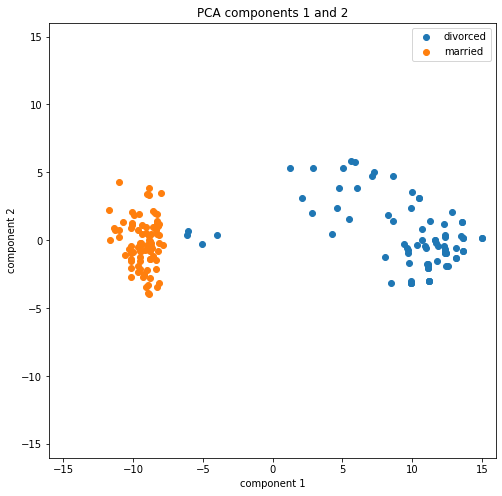

In [5]:
# Reduce the data to a number of components
n_comp = 2
pca = PCA(n_components=n_comp)
fit = pca.fit(X)
comp = fit.transform(X)

# Divide into divorced and married subset
comp_divorced = comp[divorced]
comp_married = comp[married]

# Select components
comp1 = 1
comp2 = 2

# Print the variance explained by the components
var = pca.explained_variance_ratio_
print(f'Component {comp1} accounts for {var[comp1 - 1] * 100}% of the variance.')
print(f'Component {comp2} accounts for {var[comp2 - 1] * 100}% of the variance.')

# Plot components
fig, ax = plt.subplots(figsize=(8,8))
ax = plot_components(ax, comp_divorced, comp_married, comp1, comp2, method='PCA')
ax.set_xlim(-16, 16)
ax.set_ylim(-16, 16)
plt.show()

### Discussion

The scatter plot above shows the data projected along the first two principal components calculated with the PCA method. A clear separation can be seen between the divorced and married participants. The first component accounts for 77.2% of the variance, while the second component acounts for 3.5% of the variance. Also note the four blue dots to the right of the married blob. This indicates that there are four divorced participants who, based on the questionaire, assessed their unsuccesful marriage relatively similar (at least along the principal components) to the married participants. 

# LLE

### Introduction

The Locally Linear Embedding (LLE) method reduces the dimensionality of a dataset by using the similarity of neighboring data points. The algorithm consists of 3 steps:

1. Find the $K$ nearest neighbors for each data point $\vec{X}_{i}$. 

2. Compute the weight matrix $W$ that minimizes the following error function:

$E(W) = \sum_{i}|\vec{X}_{i} - \sum_{j} W_{ij} \vec{X}_{j}|^{2}$

The weights in row $i$ of the weight matrix are only non-zero for data points $j$ that are a neighbor of $i$ and their sum should be equal to 1. The weights are calculated such that linear combinations of neighbors, $\sum_{j} W_{ij} \vec{X}_{j}$, are very close to the original points, $\vec{X}_{i}$. 

3. For the third step, another error function is minimized:

$E(Y) = \sum_{i}|\vec{Y}_{i} - \sum_{j} W_{ij} \vec{Y}_{j}|^{2}$

This time, the weight matrix is taken from step 2 and the points $Y$ are calculated such that $E(Y)$ is minimized. Crucially, the points $Y$ have the desired reduced dimensionality. The weight matrix forces the new points $Y$ to be similar to their high-dimensionality neighbors.

The LLE method works especially well when the data lie on a manifold within a higher-dimensional space, e.g. a so-called 'swiss-roll'. LLE performs poorly on non-uniformly distributed data, i.e. there significant variation in the density of data points.

We have chosen 4 different values for the number of neighbors $K$ (3, 5, 8, 16) to show the performance of the algorithm. 

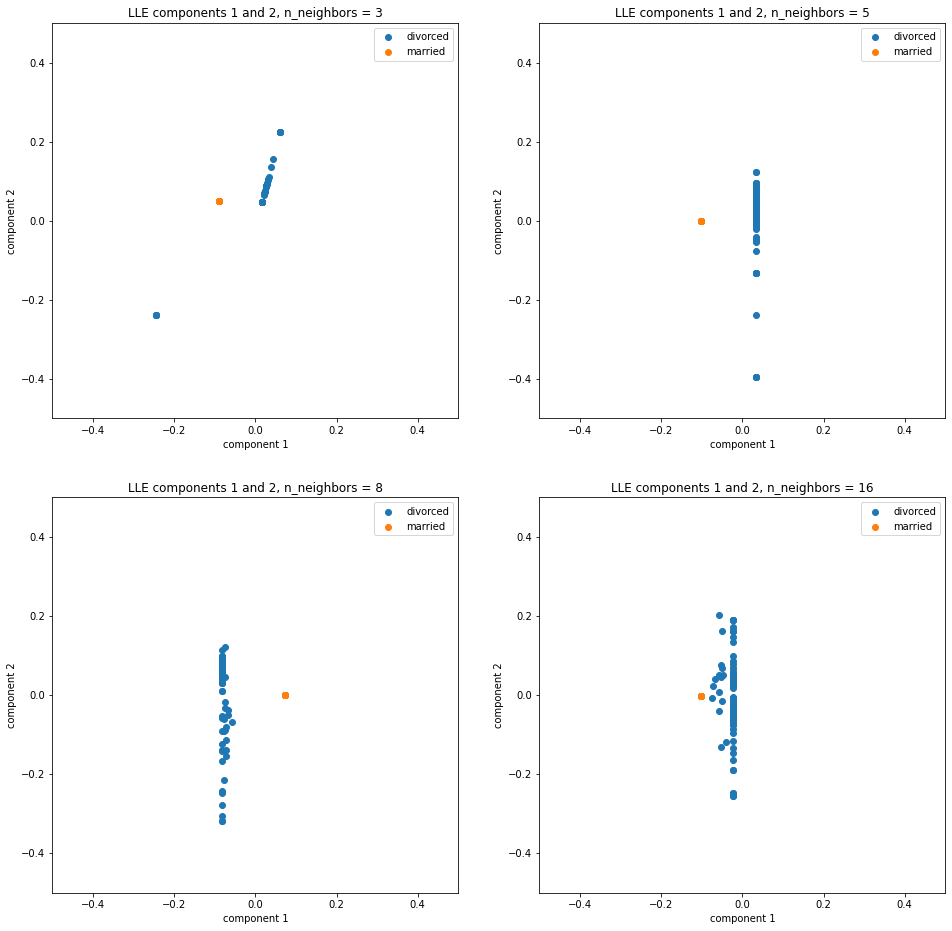

In [6]:
# Reduce the data to a number of components
n_comp = 2
n_nbs = [3, 5, 8, 16]

fig, ax = plt.subplots(2, 2, figsize=(16,16))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

# Fit the LLE model for different values of the number of neighbors 
for i in range(4):
    lle = LocallyLinearEmbedding(n_components=n_comp, n_neighbors=n_nbs[i])
    comp = lle.fit_transform(X)

    # Divide into divorced and married subset
    comp_divorced = comp[divorced]
    comp_married = comp[married]

    # Select components
    comp1 = 1
    comp2 = 2

    # Plot components
    _ax = plot_components(axes[i], comp_divorced, comp_married, comp1, comp2, method='LLE')
    _ax.set_title(f'LLE components 1 and 2, n_neighbors = {n_nbs[i]}')
    _ax.set_xlim(-0.5, 0.5)
    _ax.set_ylim(-0.5, 0.5)
plt.show()

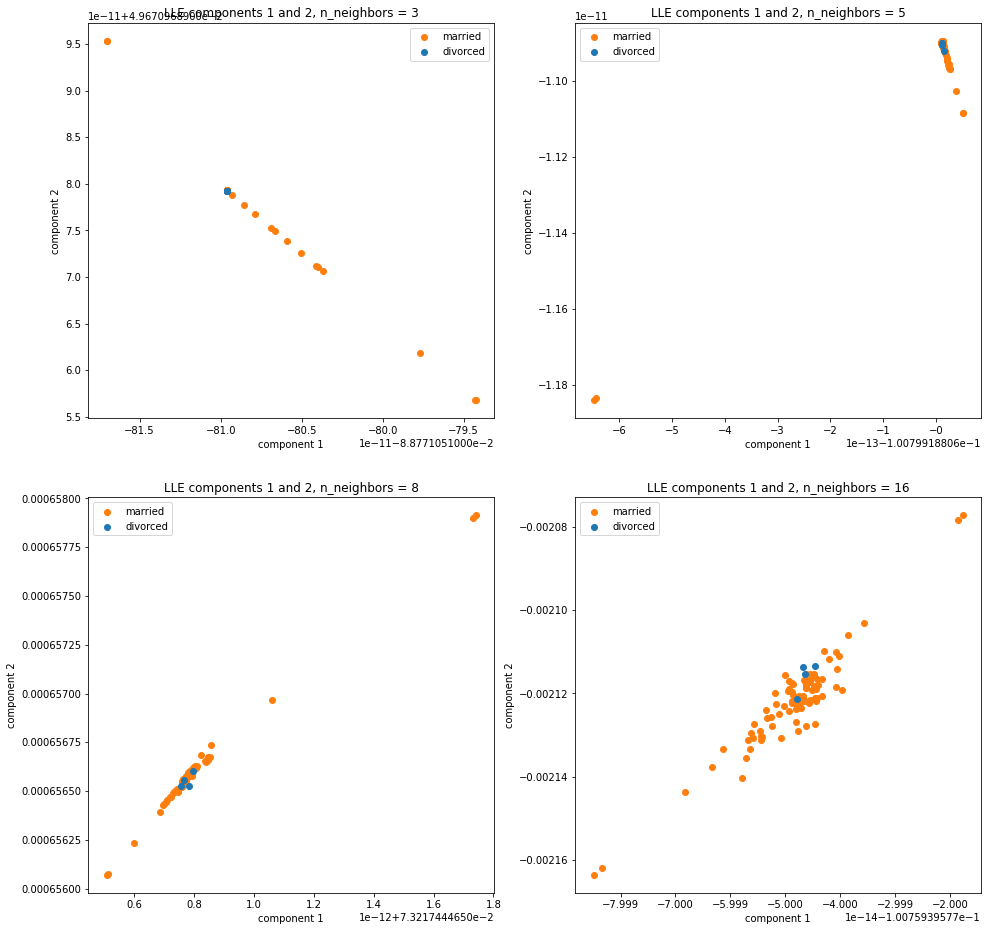

In [7]:
# Same as the previous plots, but now zoomed in to show the distribution of the married participants + outliers

fig, ax = plt.subplots(2, 2, figsize=(16,16))
axes = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]

# Fit the LLE model for different values of the number of neighbors 
for i in range(4):
    lle = LocallyLinearEmbedding(n_components=n_comp, n_neighbors=n_nbs[i])
    comp = lle.fit_transform(X)

    # Divide into divorced and married subset
    comp_divorced = comp[divorced]
    comp_married = comp[married]

    # Select components
    comp1 = 1
    comp2 = 2
    
    _ax = axes[i]

    # Plot components
    _ax.scatter(comp_married.T[comp1 - 1], comp_married.T[comp2 - 1], label='married', c='tab:orange')
    _ax.scatter(comp_divorced[[0, 4, 5, 9]].T[comp1 - 1], comp_divorced[[0, 4, 5, 9]].T[comp2 - 1], label='divorced', c='tab:blue')
    _ax.set_xlabel(f'component {comp1}')
    _ax.set_ylabel(f'component {comp2}')
    _ax.set_title(f'LLE components 1 and 2, n_neighbors = {n_nbs[i]}')
    _ax.legend()
plt.show()

### Discussion

The first set of 4 plots show the separation between married and divorced data points in the 2D space calculated by the LLE algorithm. The spread of the married data points is much smaller than that of the divorced data points, so a second set of 4 plots shows a zoom-in that focuses on the married cluster for each number of neighbours. Note from the values on the plot axes that the married points are indeed much closer together than the divorced points. The reason for the particular shape of the distribution is unclear to us, however, as stated in the introduction, LLE only works well for certain data distributions. It is likely that the data distribution is not uniform, since, judging from the PCA results, the married and divorced clusters seem to have different densities of points.

# t-SNE

### Introduction

The t-SNE algorithm first determines a probability $p_{ij}$ for each pair of data points $\vec{X}_{i}$ and $\vec{X}_{j}$. The probability is related to the euclidean distance between points. A small distance gives a high probability and a large distance a low probability. A Gaussian kernel around each point is used to calculate the probabilities, so that the probability falls of exponentially with distance. The second step is to find a new set of corresponding data points $Y$ that have the desired dimensionality (2 in our case). With the points $Y$, another set of pair probabilities $q_{ij}$ can be calculated. By minimizing the KL-divergence of distribution $p_{ij}$ from $q_{ij}$ given by

$\mathrm{KL}(P \| Q)=\sum_{i \neq j} p_{i j} \log \frac{p_{i j}}{q_{i j}}$

for the set of points $Y$ we can calculate the $Y$ which gives the distribution of points in the desired dimensionality. In constrast with the $p_{ij}$, the $q_{ij}$ are calculated using a t-distribution (instead of a Gaussian kernel) around each point. The t-distribution has higher probability in the tails of the distribution, which results in a larger separation between distant points in the reduced dimensionality.

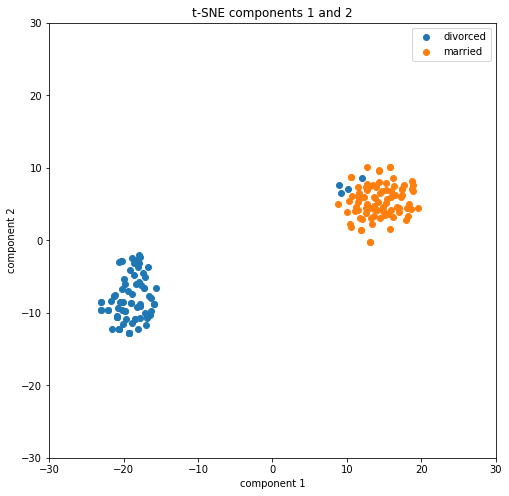

In [8]:
# Reduce the data to a number of components
n_comp = 2
tsne = TSNE(n_components=n_comp, random_state=42, init='random', learning_rate='auto')
comp = tsne.fit_transform(X)

# Divide into divorced and married subset
comp_divorced = comp[divorced]
comp_married = comp[married]

# Select components
comp1 = 1
comp2 = 2

# Plot components
fig, ax = plt.subplots(figsize=(8,8))
ax = plot_components(ax, comp_divorced, comp_married, comp1, comp2, method='t-SNE')
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
plt.show()

### Discussion

The resulting plot above, which shows the data in the dimensions calculated by the t-SNE algorithm, gives the clearest seperation of the married and divorced cluster of all three algorithms. Note that the 4 divorced outliers are embedded in the married cluster. This is slightly different from the PCA result, where the outliers are still located between the two clusters.